# Stanford Dogs 🐶 - A Classfication problem
Our group decided to tackle a project that sparked everyone's interest: using the Stanford Dogs dataset to create an image classification model capable of accurately identifying dog breeds. We wanted to make it personal and engaging by trying to identify the breed of a friend's dog.

<-- *INSERT PICTURE HERE!* -->

From a business perspective, our goal is to develop an image classification model with high accuracy in identifying dog breeds. This has various practical applications, such as enhancing pet adoption platforms by providing precise breed information, aiding veterinary services with breed-specific medical advice, and enabling personalized pet care products tailored to different breeds.

We formulated the problem as a supervised learning task, leveraging the labelled images in the Stanford Dogs dataset. Our aim is to train a model that learns to distinguish the characteristics of each breed and applies this knowledge to predict the breed of new, unseen images.

To evaluate the performance of our model, we will use several metrics. ``Accuracy`` will be our primary metric, indicating the proportion of correctly identified breeds out of all predictions. We'll also assess ``precision``, ``recall``, and the ``F1-score`` to gain deeper insights into the performance for each breed, particularly if the dataset is imbalanced. Additionally, a confusion matrix will help visualize the model's performance and pinpoint misclassifications, enabling us to refine and enhance the model further.

### 00 Getting the data 🗃️

In terms for getting the actual data, we found the dataset itself on Kaggle, a platform for data scientists and machine learning enthusiasts. It hosts a vast array of datasets, including the [Stanford Dogs dataset](https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset/code), which is a widely used benchmark for image classification tasks. 

The dataset consits of over 20,000 images of dogs, encompassing 120 different breeds, making it an ideal resourcs for training and evaluation our model.

**NOTE**: It requires an Kaggle account to download the dataset from their website

### 01 Exploring the dataset 🔍

Now that we have the dataset in our possion, we can take a closer look at it. The dataset itself consists more directly of **images** and **annotations**.

The **images** are the actually images of the different breeds stored as `.jpg`-files.
The **annotations** seems to be some kind of `.xml`-files, which contains information about where the dogs are located in the images and what breed the dog is.


First we are going to take a look at the first 3 images in the dataset. Which seems to be picture of Chihuahuas.

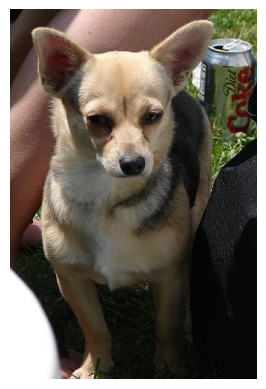

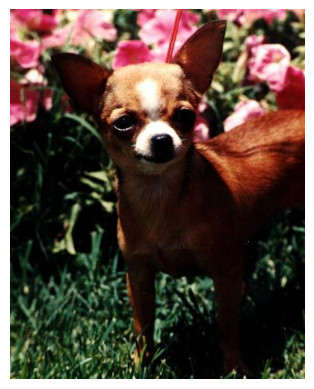

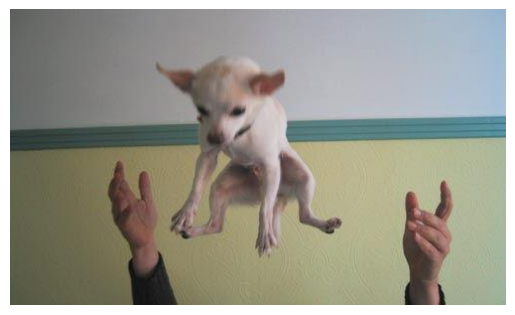

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# * This is where the original dataset is stored (Both images and annotations)
data_dir = 'base'

# ! Specify the path to the images and annotations
images_dir = os.path.join(data_dir, 'images')
annotations_dir = os.path.join(data_dir, 'annotation')

# § Utility function to get a number of files from a directory
def getFilesFromDir(directory, num_files=1):

    # ? Check if the directory exists and is not empty
    if not os.path.exists(directory) or not os.listdir(directory):
        raise FileNotFoundError(f"Directory {directory} does not exist or is empty")
    
    # ? Check if the directory contains any sub directories, if so we just take the first one
    if os.path.isdir(os.path.join(directory, os.listdir(directory)[0])):
        directory = os.path.join(directory, os.listdir(directory)[0])

    # * Append the directory to the file names
    return [os.path.join(directory, file) for file in os.listdir(directory)[:num_files]]

# * Get the first 3 images 
first_images = getFilesFromDir(images_dir,3)

# § Utility function to display image
def display_image(file_name):
    try:
        # Open an image file
        with Image.open(file_name) as img:
            # Display image
            plt.imshow(img)
            plt.axis('off')  # Hide the axes
            plt.show()
    except Exception as e:
        print(f"Error: {e}")

# Display the first image
for image in first_images:
    display_image(image)



Next we are going to take a look at the annotation files, which seems to be in an `.xml` format.

After printing the structure we can see what information the annotation contains:
- `folder` -  Where the connected image is located
- `filename` - Name of the connected image
- `size` - Which contains the height, width and depth of the images (Depth representing the RGB space.)
- `object` - Contains the label for the image (`name`) and where the dog is located in the picture (`bndbox`)

In [2]:
import xml.dom.minidom

# * Get the first annotation file
first_annotations = getFilesFromDir(annotations_dir)

# § Utility function to get the number of objects in an annotation
def display_pretty_xml(annotation_file):
    try:
        # Open the XML file and read its contents
        with open(annotation_file, 'r') as file:
            xml_content = file.read()
        
        # Parse the XML content
        dom = xml.dom.minidom.parseString(xml_content)
        
        # Function to strip unnecessary whitespace
        def strip_whitespace(node):
            if node.nodeType == node.TEXT_NODE:
                node.data = node.data.strip()
            for child in node.childNodes:
                strip_whitespace(child)
        
        # Strip whitespace from text nodes
        strip_whitespace(dom)
        
        # Pretty-print the XML
        pretty_xml_as_string = dom.toprettyxml(indent="  ")
        
        # Print the pretty XML
        print("\n".join([line for line in pretty_xml_as_string.split('\n') if line.strip()]))
    except Exception as e:
        print(f"Error: {e}")
    
# Get the number of objects in the first annotation
for annotation in first_annotations:
    print(f"XML structure of {annotation}: \n")
    display_pretty_xml(annotation)

XML structure of base\annotation\n02085620-Chihuahua\n02085620_10074: 

<?xml version="1.0" ?>
<annotation>
  <folder>02085620</folder>
  <filename>n02085620_10074</filename>
  <source>
    <database>ImageNet database</database>
  </source>
  <size>
    <width>333</width>
    <height>500</height>
    <depth>3</depth>
  </size>
  <segment>0</segment>
  <object>
    <name>Chihuahua</name>
    <pose>Unspecified</pose>
    <truncated>0</truncated>
    <difficult>0</difficult>
    <bndbox>
      <xmin>25</xmin>
      <ymin>10</ymin>
      <xmax>276</xmax>
      <ymax>498</ymax>
    </bndbox>
  </object>
</annotation>


Now we are going to take a look at the distribution of pictures for each dog breed to see if the usage of F1-score would be relevant.

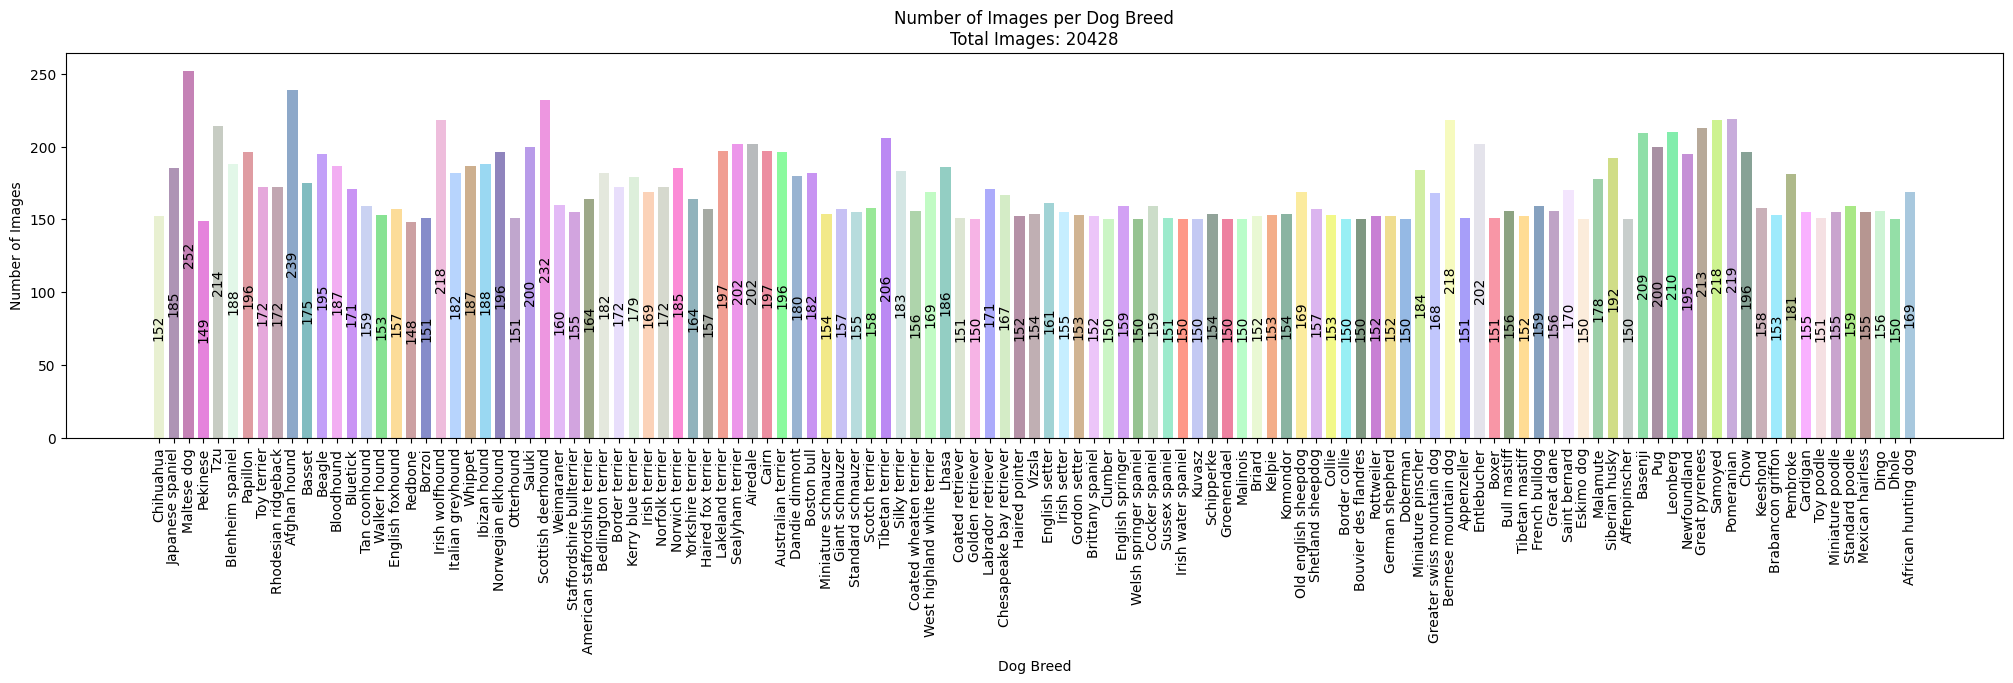

In [17]:
import random

# § Utility function to map the number of images for each dog breed in the dataset
def get_num_images_per_breed(dir_path):
    # Initialize an empty dictionary to store the count of images per breed (subdirectory)
    num_images_per_breed = {}
    
    # Loop through all the subdirectories in the directory
    for breed in os.listdir(dir_path):
        breed_dir = os.path.join(dir_path, breed)
        if os.path.isdir(breed_dir):  # Ensure it is a directory
            # Count the number of files in the subdirectory
            num_files = len([name for name in os.listdir(breed_dir) if os.path.isfile(os.path.join(breed_dir, name))])
            # Store the count in the dictionary

            # ! Clean the breed name ('n02085620-Chihuahua' -> 'Chihuahua')
            breed = breed.split('-')[-1]

            # ! Make the breed name starts with a capital letter and remove the underscores
            breed = breed.replace('_', ' ')
            breed = breed.capitalize()

            num_images_per_breed[breed] = num_files


    return num_images_per_breed

# * Get the number of images per breed
num_images_per_breed = get_num_images_per_breed(images_dir)
total_images = sum(num_images_per_breed.values())

# Generate pastel colors
def generate_pastel_color():
    r = (random.randint(0, 255) + 255) // 2
    g = (random.randint(0, 255) + 255) // 2
    b = (random.randint(0, 255) + 255) // 2
    return f'#{r:02x}{g:02x}{b:02x}'
colors = [generate_pastel_color() for _ in range(len(num_images_per_breed))]

# - Plotting
plt.figure(figsize=(25, 5))
bars = plt.bar(num_images_per_breed.keys(), num_images_per_breed.values(), color=colors, width=0.7)

# * Annotate bars with counts
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height / 2, 
        f'{height}', 
        ha='center', 
        va='center', 
        rotation=90, 
    )

# * Add labels and title
plt.xlabel('Dog Breed')
plt.ylabel('Number of Images')
plt.title(f'Number of Images per Dog Breed\nTotal Images: {total_images}')
plt.xticks(rotation=90)
plt.margins(x=0.05)

# * Display the plot
plt.show()




**NOTE**: `F1 score` is very relevant based upon that we have a HUGE imbalance, with the counts ranging from around 140 to over 250 images.

## 04 Prepare the data
Notes:
- Work on copies of the data (keep the original dataset intact)
- Write functions for all data transformation you apply, for three reasons:
    - So you can easily prepare the data next time you run your code
    - So you can apply these transformations in future projects
    - To clean and prepare the test set.


1. Data cleaning:
    - Fix or remove outliers (or keep them)
    - Fill in the missing values (e.g. with zero, mean, median, regression....) or drop their rows (or columns)
2. Feature selection (optional):
    - Drop the features that provide no useful information for the task (e.g. a customer ID is usually useless for modelling).
3. Feature engineering, where appropriate:
    - Discretize continuos features
    - Use one-hot encoding if/when relevant
    * Add promising transformations of features (e.g. $\log(x)$, $\sqrt{x}$, $x^2$, etc)
    * Aggregate features into promising new features
4. Feature scaling: standardise or normalise features

### 02 Preparing the data for training 🛠️

Now to prepare the data for training, since we are planning on use the `ImageDataGenerator` from Keras. There was some things that need to be done to the data, before it can be used. Firstly, we are going to "ditch" the annotations themselves, since the `ImageDataGenerator` automatically detects the number of classes, based upon the number of folders containing the images. So before we can use the images, we are going to be removing the suffix off of all the folders and making the first later captitalized. 

**NOTE**: In step we are also going to be seperating the images to be used for the test set, since the `ImageDataGenerator`, in the version we are running, doesn't support the `test_split` flag.

In [21]:
import shutil

# * This is where the modified dataset will be stored (Only images)
temp_dir = 'temp'

# * Creat the directories to be used for the different sets.
train_dir = os.path.join(temp_dir, 'train')
val_dir = os.path.join(temp_dir, 'val')
test_dir = os.path.join(temp_dir, 'test')

# § Utility function to create directories
def create_directories(dir_path):
    try:
        os.makedirs(dir_path, exist_ok=True)
    except Exception as e:
        print(f"Error: {e}")

# § Utility function to clean up the subdirectory name
def clean_subdirectory_name(subdirectory):
    
    # * Split by the '-'
    parts = subdirectory.split('-')

    # * Combine all parts except the first one
    name_part = '-'.join(parts[1:])

    # * Replace '_' with ' ' and same for '-'
    name_part = name_part.replace('_', ' ')
    name_part = name_part.replace('-', ' ')
    
    # Title case the name part
    return name_part.title()

# § Utility function to split the dataset into train, validation, and test sets
def split_dataset(images_dir, seed=0, train_split=0.7, val_split=0.2, test_split=0.1):
    
    # * Create the directories to store the train, validation, and test sets
    create_directories(train_dir)
    create_directories(val_dir)
    create_directories(test_dir)

    # *Get the list of subdirectories in the images directory
    subdirectories = [name for name in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, name))]

    # - Loop through each subdirectory
    for subdirectory in subdirectories:
        
        # * Print the current progress ('num of subdirectories processed / total num of subdirectories')
        print(f"Processing {subdirectories.index(subdirectory)} / {len(subdirectories)}")

        # * Get the list of image files in the subdirectory
        image_files = [name for name in os.listdir(os.path.join(images_dir, subdirectory)) if os.path.isfile(os.path.join(images_dir, subdirectory, name))]

        # ? Shuffle the list of image files with a seed
        random.seed(seed)
        random.shuffle(image_files)

        # ! Calculate the number of images for each set
        num_images = len(image_files)
        num_train = int(train_split * num_images)       # 70% of the images
        num_val = int(val_split * num_images)           # 20% of the images
        num_test = num_images - num_train - num_val     # 10% of the images

        # * Split the images into train, validation, and test sets
        train_files = image_files[:num_train]
        val_files = image_files[num_train:num_train+num_val]
        test_files = image_files[num_train+num_val:]

        # ! Clean up the subdirectory name ('n02085620-Chihuahua' -> 'Chihuahua' and 'n02099429-curly-coated_retriever' -> 'Curly coated retriever')
        print(subdirectory)
        new_subdirectory = clean_subdirectory_name(subdirectory)
        print(new_subdirectory)
        
        # * Create the subdirectory within all the sets
        train_subdir = os.path.join(train_dir, new_subdirectory)
        val_subdir = os.path.join(val_dir, new_subdirectory)
        test_subdir = os.path.join(test_dir, new_subdirectory)

        create_directories(train_subdir)
        create_directories(val_subdir)
        create_directories(test_subdir)

        # * Copy the images to the respective subdirectories
        for file in train_files:
            shutil.copy(os.path.join(images_dir, subdirectory, file), os.path.join(train_subdir, file))
        for file in val_files:
            shutil.copy(os.path.join(images_dir, subdirectory, file), os.path.join(val_subdir, file))
        for file in test_files:
            shutil.copy(os.path.join(images_dir, subdirectory, file), os.path.join(test_subdir, file))
    
    # * Print the total number of subdirectories in the test set
    print(f"Total number of subdirectories in the test set: {len(os.listdir(test_dir))}")

# ? Check if the dataset has already been split
if (os.path.exists(train_dir) and os.path.exists(val_dir) and os.path.exists(test_dir)):
    print("The dataset has already been split into train, validation, and test sets")
else: 
    # * Split the dataset
    split_dataset(images_dir)

# § Utility function to get the list of breed names
def get_breeds(dir_path, clean=True):
    # Get the list of subdirectories in the directory
    subdirectories = [name for name in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, name))]
    
    # Clean up the breed names using the 'clean_subdirectory_name' function
    if clean:
        breeds = [clean_subdirectory_name(subdirectory) for subdirectory in subdirectories]
        return breeds
    else:
        return subdirectories

# * Get the list of breed names
breeds = get_breeds(images_dir)
breeds_new = get_breeds(train_dir, clean=False) # Since the breed names are already cleaned, we set the 'clean' parameter to False

# Print the number of breeds
print(f"Number of breeds in the original dataset: {len(breeds)}")
print(f"Number of breeds in the modified dataset: {len(breeds_new)}")

# ! Make sure that are no missing breeds from the original dataset
missing_breeds = set(breeds) - set(breeds_new)

if missing_breeds:
    print(f"Missing breeds in the modified dataset: {missing_breeds}")

The dataset has already been split into train, validation, and test sets
Number of breeds in the original dataset: 120
Number of breeds in the modified dataset: 120


After we have split the images into the 3 different sets, we are just gonna ensure that the ratios in check. To do that we are gonna check the 'Chihuahua' set.

In [6]:
# § Utility function to get the number of images in each set for a specific breed
def get_num_images_per_set(breed):
    # * Get the number of images for the breed in the train, validation, and test sets
    train_breed_dir = os.path.join(train_dir, breed)
    val_breed_dir = os.path.join(val_dir, breed)
    test_breed_dir = os.path.join(test_dir, breed)

    # * Count the number of images in each set
    num_train = len([name for name in os.listdir(train_breed_dir) if os.path.isfile(os.path.join(train_breed_dir, name))])
    num_val = len([name for name in os.listdir(val_breed_dir) if os.path.isfile(os.path.join(val_breed_dir, name))])
    num_test = len([name for name in os.listdir(test_breed_dir) if os.path.isfile(os.path.join(test_breed_dir, name))])
    num_total = num_train + num_val + num_test

    return num_train, num_val, num_test, num_total

# * Get the number of images for a specific breed
breed = 'Chihuahua'
num_train, num_val, num_test, num_total = get_num_images_per_set(breed)
print(f"\nNumber of images for {breed} in the train set: {num_train} ({num_train/num_total*100:.2f}%)")
print(f"Number of images for {breed} in the validation set: {num_val} ({num_val/num_total*100:.2f}%)")
print(f"Number of images for {breed} in the test set: {num_test} ({num_test/num_total*100:.2f}%)")


# 2nd breed
breed = 'Curly Coated Retriever'
num_train, num_val, num_test, num_total = get_num_images_per_set(breed)
print(f"\nNumber of images for {breed} in the train set: {num_train} ({num_train/num_total*100:.2f}%)")
print(f"Number of images for {breed} in the validation set: {num_val} ({num_val/num_total*100:.2f}%)")
print(f"Number of images for {breed} in the test set: {num_test} ({num_test/num_total*100:.2f}%)")


Number of images for Chihuahua in the train set: 106 (69.74%)
Number of images for Chihuahua in the validation set: 30 (19.74%)
Number of images for Chihuahua in the test set: 16 (10.53%)

Number of images for Curly Coated Retriever in the train set: 105 (69.54%)
Number of images for Curly Coated Retriever in the validation set: 30 (19.87%)
Number of images for Curly Coated Retriever in the test set: 16 (10.60%)


<-- *Explanation for the below approach* -->

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import scipy

# * Define paths to the train, validation, and test sets
data_dir = 'temp'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# * Create the ImageDataGenerator data generator
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
)

# ! Load all images to be used for the training set.
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# ! Load all images to be used for the validation set.
validation_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# ! Load all images to be used for the test set.
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

Found 14355 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.
Found 2153 images belonging to 120 classes.


#### 02A - ResNet50 + SGD

#####  Compiling the model ⚙️

The next step in the process is to compile the model itself. But before that we have define what **Loss function**, **Optimizer** and **Metrics** we are going to be using on this model.

For the **Loss function** We have a few different options:

(*Name a few different loss functions that would make sense to use for this project.*)

For the **Optizimers** we also have a few different options:
- *Adam*, *SGD*, *RMSProp* etc.

For the **Metrcis** we also have a few different options:
- *Accuarcy*, *Precision*, *Recall*, *F1 score* etc.


In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

# ? Load pre-trained model, if available
if os.path.exists('model.h5'):
    print("Loading the pre-trained model....")
    model = tf.keras.models.load_model('model.h5')

# ? Otherwise, we need to create a new instance of the model.
else:
    print("Creating a new model....")
    # Load the ResNet50 model, pre-trained on ImageNet
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Add custom layers on top of the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)

    # Define the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Unfreeze the last few layers of the base model
    for layer in base_model.layers[-10:]:
        layer.trainable = True

    # Compile the model
    model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

Loading the pre-trained model....


##### Training the model 🏋️‍♀️

The next step in the process is to train the now compiled model on our data. Here we also have a little exploratory work in figuring out:
- What *batch size* should we use?
- What *number of epochs* should we use?
- Is the model *overfitting* or *underfitting*?

In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# - Function the limit the number of batches per epoch for faster iterations.
def limit_batches(generator, max_batches):
    while True:
        for i, (x_batch, y_batch) in enumerate(generator):
            if i >= max_batches:
                break
            yield (x_batch, y_batch)

# * Current limits:
max_train_batches = 100 # It's a good starting point, but needs to be adjusted for better results.
max_validation_batches = 25 # It's a good starting point.

# ? Callbacks and their usage
# 1. Reduce learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)
# 2. Stop training when a monitored quantity has stopped improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
# 3. Save the model after every epoch.
model_checkpoint = ModelCheckpoint('model.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

# ! 1st round of training (20 epochs, validation accuracy of 42.77%)
# ! 2nd round of training (20 epochs, validation accuracy of 61.05%)
# ! 3rd round of training (20 epochs, validation accuracy of 66.88%)
# ! 4th round of training (20 epochs, validation accuracy of 69.92%)
# ! 5th round of training (20 epochs, validation accuracy of 72.39%)
# ! 6th round of training (20 epochs, validation accuracy of 72.95%)
# The new split of data seems to quite effectively to have improved the model's performance.
history = model.fit(
    limit_batches(train_generator, max_train_batches),
    validation_data=limit_batches(validation_generator, max_validation_batches),
    epochs=20, # Use a small number of epochs to speed up the process (10 epochs = 5 mins on GPU - With validation accuracy of 0.18 after 10 epochs)
    steps_per_epoch=max_train_batches,
    validation_steps=max_validation_batches
)

Epoch 1/20
100/100 [==============================] - 32s 324ms/step - loss: 10.1937 - accuracy: 0.7172 - val_loss: 10.2700 - val_accuracy: 0.7000
Epoch 2/20
100/100 [==============================] - 35s 355ms/step - loss: 10.1695 - accuracy: 0.7153 - val_loss: 10.2023 - val_accuracy: 0.6946
Epoch 3/20
100/100 [==============================] - 31s 308ms/step - loss: 10.0764 - accuracy: 0.7242 - val_loss: 10.2016 - val_accuracy: 0.6775
Epoch 4/20
100/100 [==============================] - 30s 300ms/step - loss: 10.0690 - accuracy: 0.7153 - val_loss: 10.1304 - val_accuracy: 0.7038
Epoch 5/20
100/100 [==============================] - 30s 300ms/step - loss: 10.0184 - accuracy: 0.7222 - val_loss: 10.0471 - val_accuracy: 0.7025
Epoch 6/20
100/100 [==============================] - 30s 303ms/step - loss: 9.9781 - accuracy: 0.7169 - val_loss: 9.9687 - val_accuracy: 0.7212
Epoch 7/20
100/100 [==============================] - 29s 293ms/step - loss: 9.9626 - accuracy: 0.7185 - val_loss: 9.954

##### Evaluating the model 📊
<-- *A tiny bit text about evaluation...* -->

In [20]:
val_loss, val_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Validation accuracy: {val_accuracy * 100:.2f}%')

# Save the model
model.save('model.h5')

67/67 [==============================] - 17s 253ms/step - loss: 9.4654 - accuracy: 0.7295
Validation accuracy: 72.95%


## 05 Short-list promising models
We expect you to do some additional research and train at **least** one model per team member!

1. Train mainly quick and dirty models from different categories (e.g. linear, SVM, Random Forests etc.) using default parameters
2. Measure and compare their performance
3. Analyse the most significant variables from each algorithm.
4. Analyse the types of errors the models make
5. Have a quick round of feature selection and engineering if necessary
6. Have one or two more quick iterations of the five previous steps.
7. Short-list the top three to five most promising models, prefeering models that make *different* types of errors?

## 06 Fine-tune the system

1. Fine-tune the hyperparameters
2. Once you are confident about our final model, measure its performance on test set to estimate the generalisation error.


## 07 Present your solution

1. Document what you ahve done
2. Create a *nice* 15 minute video presentation with slides
    - Make sure you highlight the big picture first.
3. Explain why your solutions achieves the business objective
4. Don't forget to present interesting points you noticed along the way:
    - Describe what worked and what did not.
    - List your assumptions and your model's limitations.
5. Ensure your key finds are communicated through nice visualisations or easy-to-remember statements (e.g. "*The median income is the number-one predictor of housing prices*")
6. Upload the presentation to some online platform, e.g. Youtube, Vimeo, and supply a link to the video in the notebook.